One of core problems SVMs need to solve is the quadratic problem:<br><br>
$$
\textrm{minimizing} \;\;\;\frac{1}{2}W^{T}W \;\;\; \textrm{subject to} \;\;\; t_{i}(W^{T}x_{i}+b)\geqslant 1  \;\;\;  \forall i\in n
$$ <br>

Covert this to the dual problem, we need to solve(for the full derivation please refer to my origin post):
$$max_{\lambda}=\sum_{i=1}^{n}\lambda _{i}-\frac{1}{2}\lambda ^{T}\lambda t t^{T}\mathbf{K}(x_{i},x_{j})\lambda$$
$$\textrm{subject to} \;\;\; 0\leq \lambda _{i}\leq C, \;\;\;\sum_{i=1}^{n}\lambda _{i}t_{i}=0$$<br><br>
We will use cvxopt, which is a convex optimisation package that includes a wrapper for Python. the approach is fairly simple: we choose a kernel and then for given data, assemble the relevant quadratic problem and its constraints as matrices, and then pass them to the solver, which finds the decision boundary and necessary support vectors for us. These are then used to build a classifier for that training data.

The cvxopt quadratic program solver is cvxopt.solvers.qp(). This method takes the following inputs cvxopt.solvers.qp(P, q, G, h, A, b) and then solves:<br><br>
$$
\textrm{minimizing} \;\;\;\frac{1}{2}x^{T}Px+q^{T}x \;\;\; \textrm{subject to} \;\;\; Gx\leq h, \;\;Ax=b$$<br>
where $x$ is the variable we are solving for, which is $\lambda$ for us. We need to multiply the objective function by -1, and set $P=t_{i}t_{j}K$ and $q$ is just a column vector containing −1s. $A=t$. <br>
We also want to include two constraints $(0\leq\lambda_{i} \; \textrm{and} \; \lambda_{i} \leq C)$. To do this, we double up on the number of constraints, multiplying the ones where we want $\geq$ instead of $\leq$ by -1. <br><br>
Assemble all the code can then be written as:

In [264]:
import numpy as np
import mkl as mkl 
import sys
sys.path.append('C:\Anaconda3\envs\ML\Lib\site-packages')
import cvxopt as cvxopt
from cvxopt import solvers

class SVM:
    def __init__(self, kernel = 'polynomial', C = None, sigma = 1., degree = 1., threshold = 0.0, gamma = None, coef = 0.0):
        self.kernel = kernel
        if self.kernel == 'polynomial':
            self.degree = 1.
        self.C = C
        self.sigma = sigma
        self.degree = degree
        self.threshold = threshold
        self.gamma = gamma
        self.coef = coef
    
    def build_kernel(self, X):
        if self.gamma is None:
            self.gamma = 1/np.shape(X)[1]
            
        self.K = np.dot(X, X.T)
        
        if self.kernel == 'polynomial':
            self.K = (1 + 1./self.sigma * self.K)**self.degree
        
        if self.kernel == 'rbf':
            self.xsquared = (np.diag(self.K)*np.ones((1,self.N))).T
            b = np.ones((self.N,1))
            self.K -= 0.5*(np.dot(self.xsquared,b.T) + np.dot(b,self.xsquared.T))
            self.K = np.exp(self.K/(2.*self.sigma**2))

        if self.kernel == 'sigmoid':
            self.K = np.tanh(self.gamma * self.K + self.coef)
            
    def train(self,X, targets):
        self.N = np.shape(X)[0]
        self.build_kernel(X)

        # Assemble the matrices for the constraints
        P = targets*targets.transpose()*self.K
        q = -np.ones((self.N,1))
        if self.C is None:
            G = -np.eye(self.N)
            h = np.zeros((self.N,1))
        else:
            G = np.concatenate((np.eye(self.N),-np.eye(self.N)))
            h = np.concatenate((self.C*np.ones((self.N,1)),np.zeros((self.N,1))))
        A = targets.reshape(1,self.N)
        b = 0.0

        # Call the quadratic solver
        solver = cvxopt.solvers.qp(cvxopt.matrix(P),cvxopt.matrix(q),cvxopt.matrix(G),cvxopt.matrix(h), cvxopt.matrix(A), cvxopt.matrix(b))
        
        # retrieve the Lagrange multipliers
        lambdas = np.array(solver['x'])
        
        # retrieve support vectors indices that are vectors with non-zero Lagrange multipliers
        self.sv = np.where(lambdas > self.threshold)[0]
        
        # retrieve corresponding support vector points
        self.X = X[self.sv,:]
        self.lambdas = lambdas[self.sv]
        self.targets = targets[self.sv]
        
        # calcualte optimal b
        self.b = np.sum(self.targets)
        for n in range(len(self.sv)):
            self.b -= np.sum(self.lambdas * self.targets * np.reshape(
                      self.K[self.sv[n], self.sv],
                      (len(self.sv), 1))
            )
        self.b /= len(self.lambdas)
        return self
        
    
    def predict(self, Y, soft = False):
        if self.kernel == 'polynomial':
            K = (1 + 1./self.sigma * np.dot(Y, self.X.T))**self.degree
            self.y = np.zeros((np.shape(Y)[0], 1))
            
            for j in range(np.shape(Y)[0]):
                for i in range(len(self.sv)):
                    self.y[j] += self.lambdas[i] * self.targets[i] * K[j, i]
                    
            self.y += self.b
            
            if soft:
                return self.y
            else:
                return np.sign(self.y)
            
        if self.kernel == 'rbf':
            K = np.dot(Y,self.X.T)
            
            c = (1./self.sigma * np.sum(Y**2,axis=1)*np.ones((1,np.shape(Y)[0]))).T 
            c = np.dot(c,np.ones((1,np.shape(K)[1])))
            aa = np.dot(self.xsquared[self.sv],np.ones((1,np.shape(K)[0]))).T
            K = K - 0.5*c - 0.5*aa
            K = np.exp(K/(2.*self.sigma**2))
        
            self.y = np.zeros((np.shape(Y)[0], 1))
            
            for j in range(np.shape(Y)[0]):
                for i in range(len(self.sv)):
                    self.y[j] += self.lambdas[i] * self.targets[i] * K[j, i]
                    
            self.y += self.b
            
            if soft:
                return self.y
            else:
                return np.sign(self.y)
            
        if self.kernel == 'sigmoid':
            K = np.dot(Y,self.X.T)
            K = np.tanh(self.gamma * K + self.coef)
            
            self.y = np.zeros((np.shape(Y)[0], 1))
            for j in range(np.shape(Y)[0]):
                for i in range(len(self.sv)):
                    self.y[j] += self.lambdas[i] * self.targets[i] * K[j, i]
                    
            self.y += self.b
            
            if soft:
                return self.y
            else:
                return np.sign(self.y)

In [265]:
# load data
iris = np.loadtxt('iris.csv',delimiter=',')
# select 2 feature for show results on 2-d map
features = iris[:,:2]
target = iris[:,-1]
features.shape = (features.shape[0],features.shape[1])
target.shape = (target.shape[0],1)

In [ ]:
# training and testing split
from sklearn.cross_validation import train_test_split
from sklearn import svm
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 123)

     pcost       dcost       gap    pres   dres
 0: -5.4521e+01 -1.8499e+02  6e+02  2e+00  1e-15
 1: -3.8077e+01 -1.2020e+02  8e+01  4e-16  1e-15
 2: -4.4365e+01 -5.5135e+01  1e+01  6e-16  1e-15
 3: -4.8626e+01 -5.0594e+01  2e+00  1e-15  9e-16
 4: -4.9522e+01 -4.9820e+01  3e-01  7e-16  7e-16
 5: -4.9664e+01 -4.9679e+01  2e-02  8e-16  7e-16
 6: -4.9672e+01 -4.9672e+01  2e-04  4e-16  8e-16
 7: -4.9672e+01 -4.9672e+01  2e-06  4e-16  9e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.3465e+01 -1.8267e+02  7e+02  2e+00  1e-10
 1: -3.8012e+01 -1.1932e+02  1e+02  2e-01  1e-10
 2: -3.9838e+01 -5.2213e+01  1e+01  2e-02  9e-11
 3: -4.3377e+01 -4.6919e+01  4e+00  4e-03  9e-11
 4: -4.4495e+01 -4.5417e+01  1e+00  7e-04  1e-10
 5: -4.4757e+01 -4.5048e+01  3e-01  2e-04  1e-10
 6: -4.4873e+01 -4.4889e+01  2e-02  3e-06  1e-10
 7: -4.4880e+01 -4.4880e+01  2e-04  3e-08  1e-10
 8: -4.4880e+01 -4.4880e+01  2e-06  3e-10  1e-10
Optimal solution found.
     pcost       dcost 

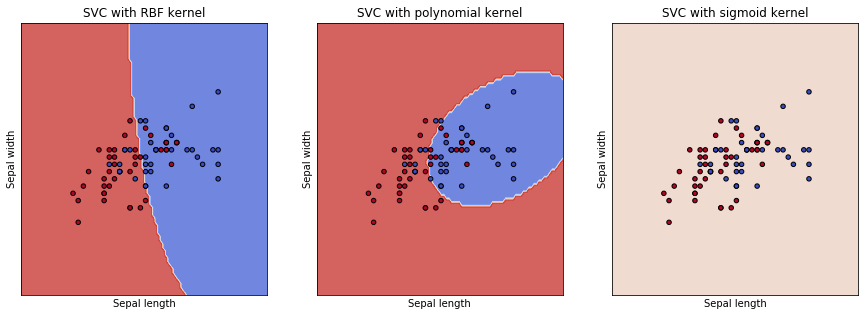

In [269]:
# plot contours
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# make meshgrid
def make_meshgrid(x, y, h=.05):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

import matplotlib.pyplot as plt
# define three SVMs with different kernel and parameters
models = [SVM(kernel = 'rbf', C = 1),
         SVM(kernel = 'polynomial', degree = 3, C = 1),
         SVM(kernel = 'sigmoid', gamma = 0.7, C = 0)]

# training models
models = [clf.train(X_train,y_train) for clf in models]
titles = ('SVC with RBF kernel',
          'SVC with polynomial kernel',
          'SVC with sigmoid kernel')
fig, sub = plt.subplots(1, 3,figsize=(15,5))
X0, X1 = X_train[:, 0], X_train[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title in zip(models,titles):
    output = clf.predict(X_test,soft=False)
    err1 = np.where((output==1.) & (y_test==-1.))[0]
    err2 = np.where((output==-1.) & (y_test==1.))[0]
    print('*******************************')
    print(title)
    print("Class 1 errors ",len(err1)," from ",len(y_test[y_test==-1]))
    print("Class 2 errors ",len(err2)," from ",len(y_test[y_test==1]))
    print("Test accuracy ",1. -(float(len(err1)+len(err2)))/ (len(y_test[y_test==1]) + len(y_test[y_test==-1])))
    print()
    
for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_train.ravel(), cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.show()